# Reproduction and GAN Implementation Analysis

# 1. Reproduction

This notebook will be analyzing the results of the reproduction of the results from the original World Models paper. Weights for the VAE can be found in `vae/weights.h5`, and weights for the MDN-RNN can be found in `rnn/weights.h5`. 

## VAE

In [29]:
import numpy as np
from vae.arch import VAE
from gan.arch import GAN
import matplotlib.pyplot as plt
import os
from IPython import display
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
from tensorflow.keras.utils import plot_model
import json
from matplotlib import pyplot as plt
import numpy as np

np.set_printoptions(precision=4, suppress = True)

In [27]:
vae = VAE()
vae.set_weights('./vae/weights.h5')
DIR_NAME = './data/rollout/'
file = os.listdir(DIR_NAME)[200]
print(file)
obs_data = np.load(DIR_NAME + file)['obs']
print(obs_data.shape)

69526869.npz
(300, 64, 64, 3)


KeyboardInterrupt: 

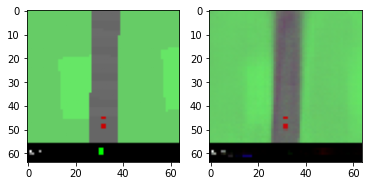

In [28]:
# VAE output with random policy for one episode
for idx in range(0,300):
    plt.gca().cla() 
    
    obs = obs_data[idx]
    z_decoded = vae.full_model.predict(np.array([obs]))[0]
    
    plt.subplot(121)
    plt.imshow( obs)
    plt.subplot(122)
    plt.imshow( z_decoded)
    
#     plt.show()
    display.clear_output(wait=True)
    display.display(plt.gcf())

As you can see, the VAE visually replicates the input images adequately. This means it is likely that `z` encodes important information about the input pixels. The model above was used to generate training data for the MDN-RNN. Use `check_04_rnn.ipynb` to analyze the results from the RNN.

## Controller

The controller was trained for 171 episodes with a maximum episode length of 300 time steps. As can be seen below, the controller reward steadily increased over time. However, learning the policy was quite slow, with each episode taking many minutes to compute. As can be seen below, there seems to be a relatively good balance of exploration and exploitation throughout training, which is one explanation for the steady rise in reward. The final weights and training history can be found in `log`.

In [30]:
data = json.load(open('log/car_racing.cma.4.8.hist.json'))

In [31]:
xs = [i[0] for i in data]
ys = [i[3] for i in data]

In [32]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

In [33]:
ys_rm = moving_average(ys, 10)

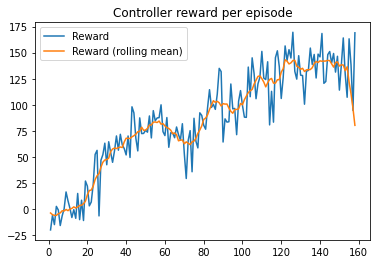

<Figure size 432x288 with 0 Axes>

In [34]:
fig, ax = plt.subplots()
ax.plot(xs, ys, label='Reward')
ax.plot(xs, ys_rm, label='Reward (rolling mean)')
ax.set_title('Controller reward per episode')
ax.legend()
plt.show()
plt.savefig('controller_reward.png')

# GAN Results Analysis

The pipeline was replicated with a slightly different architecture that utilizes a Generative Adverserial network in combination with a Convolutional Variational Autoencoder to produce the latent $z$ variable. The architecture for a VAEGAN is as follows.

Just like with the vanilla VAE, an encoder network turns the input $x$ into a latent vector $z$. The generator then takes the role of the decoder, turning $z$ into a $\hat{x}$ which should reproduce the original image. However, instead of the similarity between $\hat{x}$ and $x$ being used as the metric from which to train the network, an additional network known as the discriminator is used to learn a similarity metric between $x$ and $\hat{x}$. As described in [this paper](https://arxiv.org/pdf/1512.09300.pdf), this allows the network to encode richer information than simply pixel-to-pixel similarity. 

Trained for approx. 20 epochs with N=100-200

In my experiments, I found that this causes the reconstruction to not resemble the original image as closely as the vanilla CVAE. However, the controller is still found to be competitive with the VAE approach when it and the RNN are trained with $z$s produced by the GAN. This implies that, while the generator does not visually recreate the original image, important features are still being encoded in its latent $z$. This may be because the discriminator is learning a similarity metric that is more complex than a direct visual recreation. Furthermore the VAE-GAN is slower and more complex to train than the VAE, and more training coult potentially cause the model to converge. 

The specific implementation of the VAE-GAN architecture can be found in `gan/arch.py`. The controller model has been updated to work with the VAE-GAN in `model_gan.py`. Furthermore, a similar pipeline has been created and this experiment can be replicated by running the following python files:

- Collect rollouts with `01_generate_data.py`, or use rollouts present in `data/rollouts`
- run `train_gan.py`
- run `generate_rnn_data_gan.py`
- run `train_rnn_gan.py`
- run `train_controller_gan.py`

The following demonstrates the visual recreation of the VAE-GAN. While not an exact recreation, the RNN and controller are nonetheless shown to eventually learn to use the VAE-GAN's $z$ variable effectively in the car racing environment

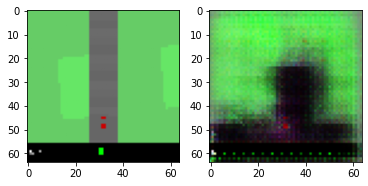

KeyboardInterrupt: 

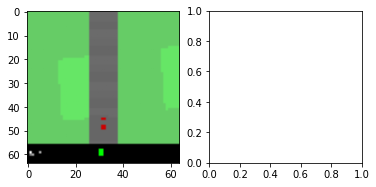

In [35]:
gan = GAN()
gan.set_weights('./gan/weights_1.h5')

for idx in range(0,300):
    plt.gca().cla() 
    
    obs = obs_data[idx]
    z_decoded = gan.full_model.predict(np.array([obs]))[0]
    
    plt.subplot(121)
    plt.imshow( obs)
    plt.subplot(122)
    plt.imshow( z_decoded)
    
#     plt.show()
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [38]:
data_gan = json.load(open('log/car_racing.cma.10.4.gan.hist.json'))
xs_gan = [i[0] for i in data_gan]
ys_gan = [i[3] for i in data_gan]
ys_gan_rm = moving_average(ys_gan, 10)

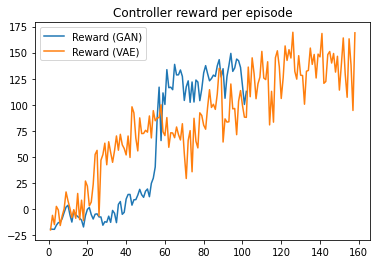

<Figure size 432x288 with 0 Axes>

In [39]:
fig, ax = plt.subplots()
ax.plot(xs_gan, ys_gan, label='Reward (GAN)')
ax.plot(xs, ys, label='Reward (VAE)')
# ax.plot(xs_gan, ys_gan_rm, label='Reward (rolling mean)')
ax.set_title('Controller reward per episode')
ax.legend()
plt.show()
plt.savefig('controller_reward.png')

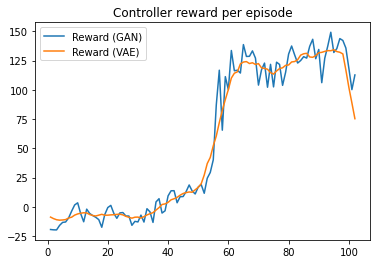

<Figure size 432x288 with 0 Axes>

In [40]:
fig, ax = plt.subplots()
ax.plot(xs_gan, ys_gan, label='Reward (GAN)')
ax.plot(xs_gan, ys_gan_rm, label='Reward (VAE)')
# ax.plot(xs_gan, ys_gan_rm, label='Reward (rolling mean)')
ax.set_title('Controller reward per episode')
ax.legend()
plt.show()
plt.savefig('controller_reward.png')